In [1]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers


In [2]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [4]:
df = pd.read_csv("creditcard.csv")

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


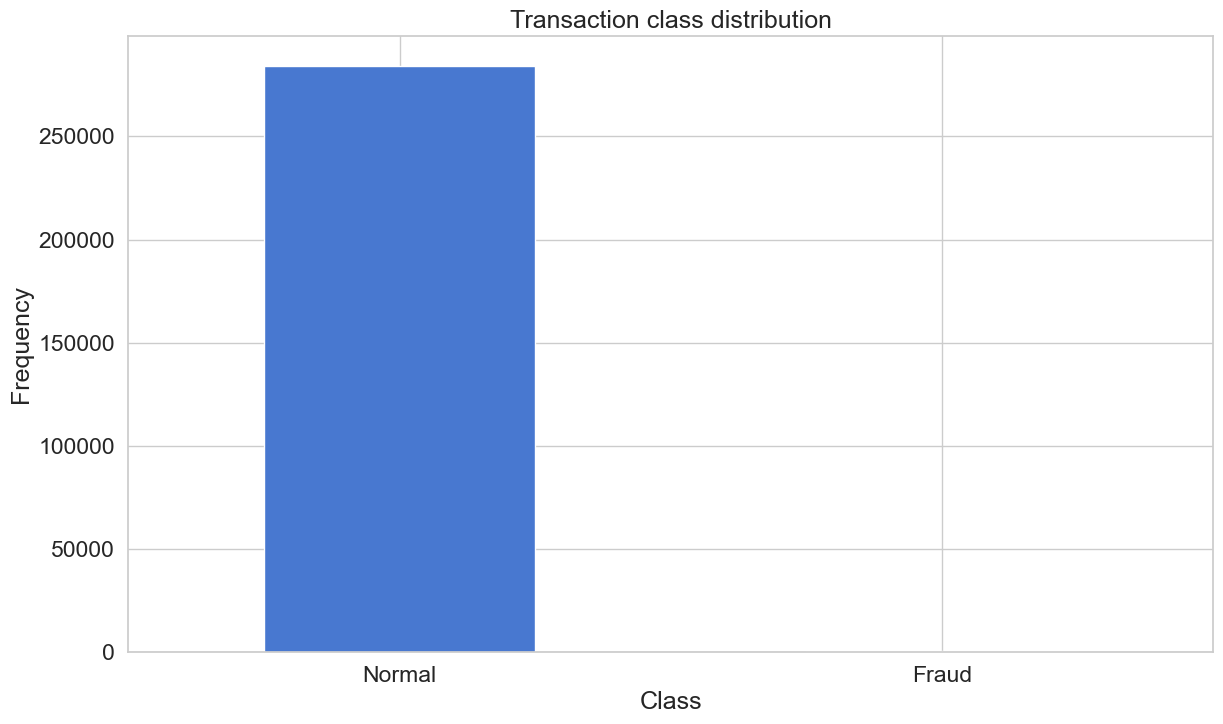

In [6]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [10]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [11]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [12]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [13]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

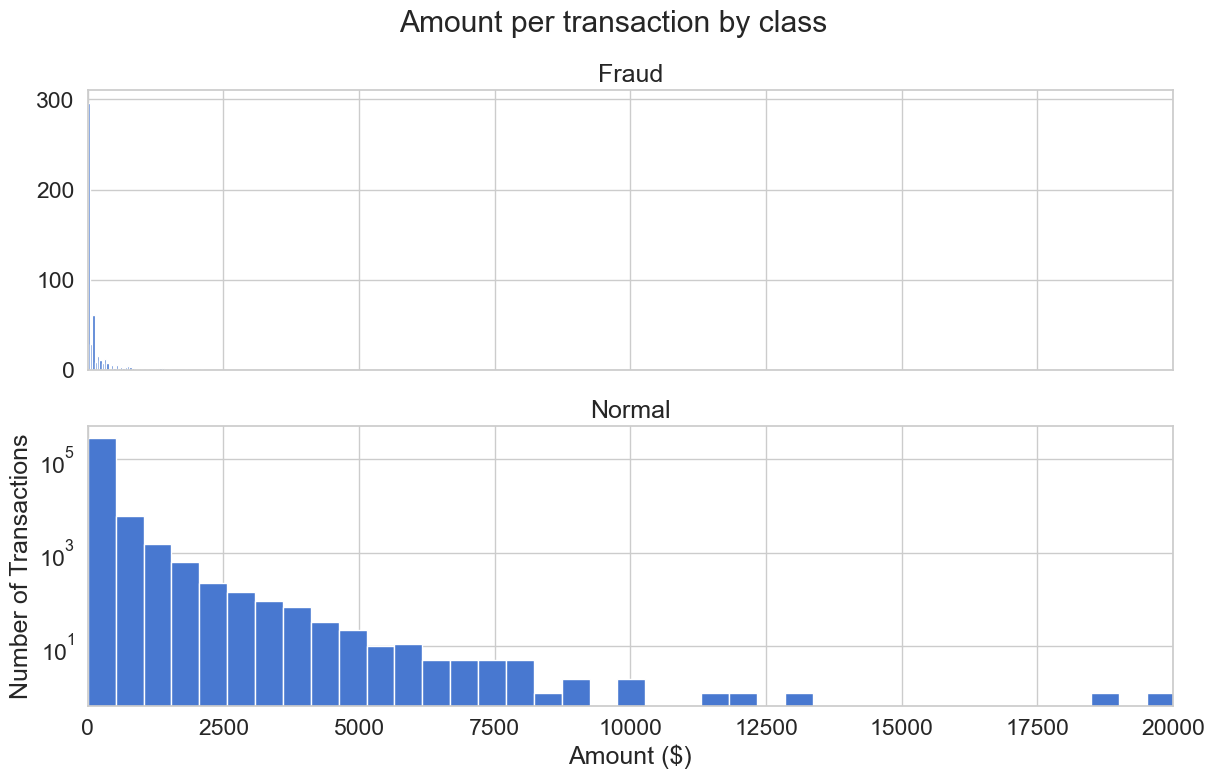

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

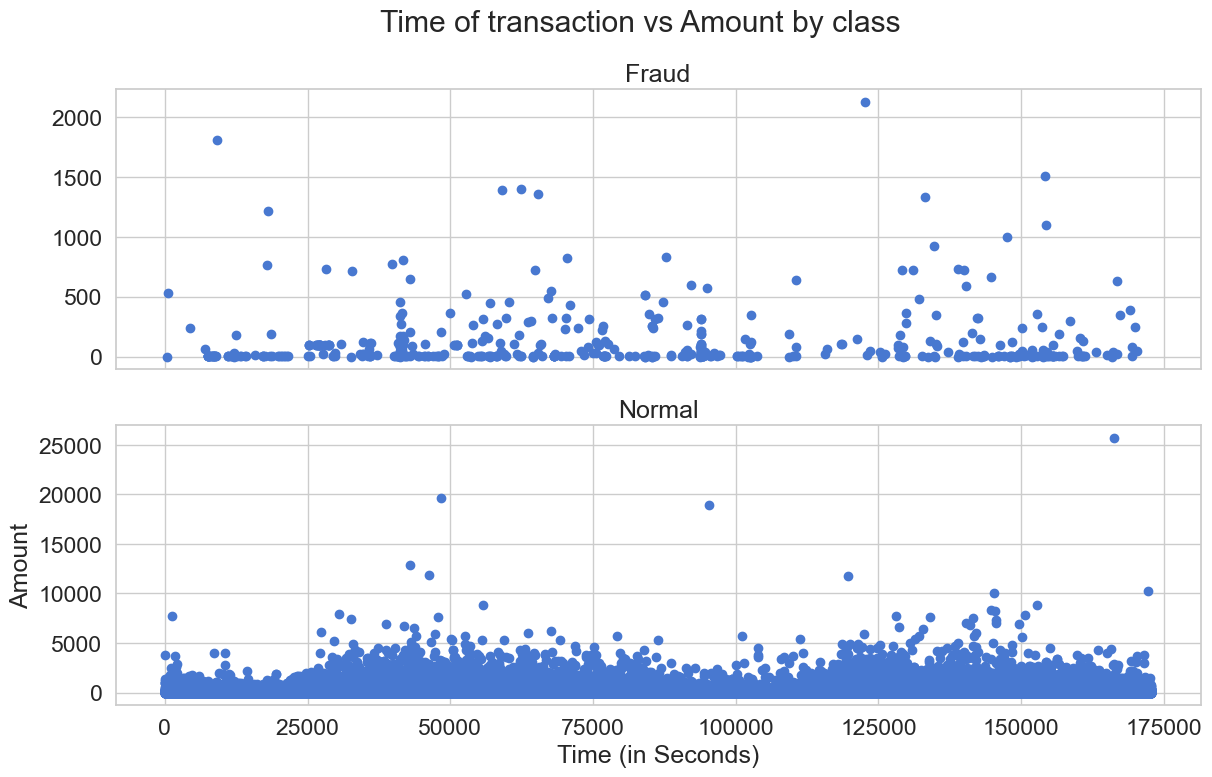

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [16]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [17]:
# 모델을 오직 정상 거래기록으로만 훈련
# 정상 거래기록을 테스트셋에 넣으면 모델의 성능을 평가

In [18]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)


X_train = X_train.values
X_test = X_test.values

X_train.shape

(227451, 29)

In [26]:
X_data = data.drop(['Class'], axis = 1)
y_data = data['Class']

x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)
#x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

x_train_y0 = x_train[y_train == 0]
x_train_y1 = x_train[y_train == 1]

#x_valid_y0 = x_valid[y_valid == 0]
#x_valid_y1 = x_valid[y_valid == 1]

In [30]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [32]:
#nb_epoch = 100
nb_epoch = 10
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(x_train_y0, x_train_y0,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split = 0.2,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
5686/5686 [==============================] - 21s 3ms/step - loss: 0.7981 - accuracy: 0.5950 - val_loss: 0.7636 - val_accuracy: 0.6549
Epoch 2/10
5686/5686 [==============================] - 19s 3ms/step - loss: 0.7278 - accuracy: 0.6673 - val_loss: 0.7358 - val_accuracy: 0.6731
Epoch 3/10
5686/5686 [==============================] - 19s 3ms/step - loss: 0.7110 - accuracy: 0.6886 - val_loss: 0.7248 - val_accuracy: 0.6929
Epoch 4/10
5686/5686 [==============================] - 19s 3ms/step - loss: 0.7044 - accuracy: 0.6988 - val_loss: 0.7217 - val_accuracy: 0.6961
Epoch 5/10
5686/5686 [==============================] - 21s 4ms/step - loss: 0.6999 - accuracy: 0.7009 - val_loss: 0.7154 - val_accuracy: 0.6973
Epoch 6/10
5686/5686 [==============================] - 21s 4ms/step - loss: 0.6962 - accuracy: 0.7080 - val_loss: 0.7151 - val_accuracy: 0.6958
Epoch 7/10
5686/5686 [==============================] - 20s 4ms/step - loss: 0.6940 - accuracy: 0.7100 - val_loss: 0.7111 - val_ac

In [33]:
autoencoder = load_model('model.h5')

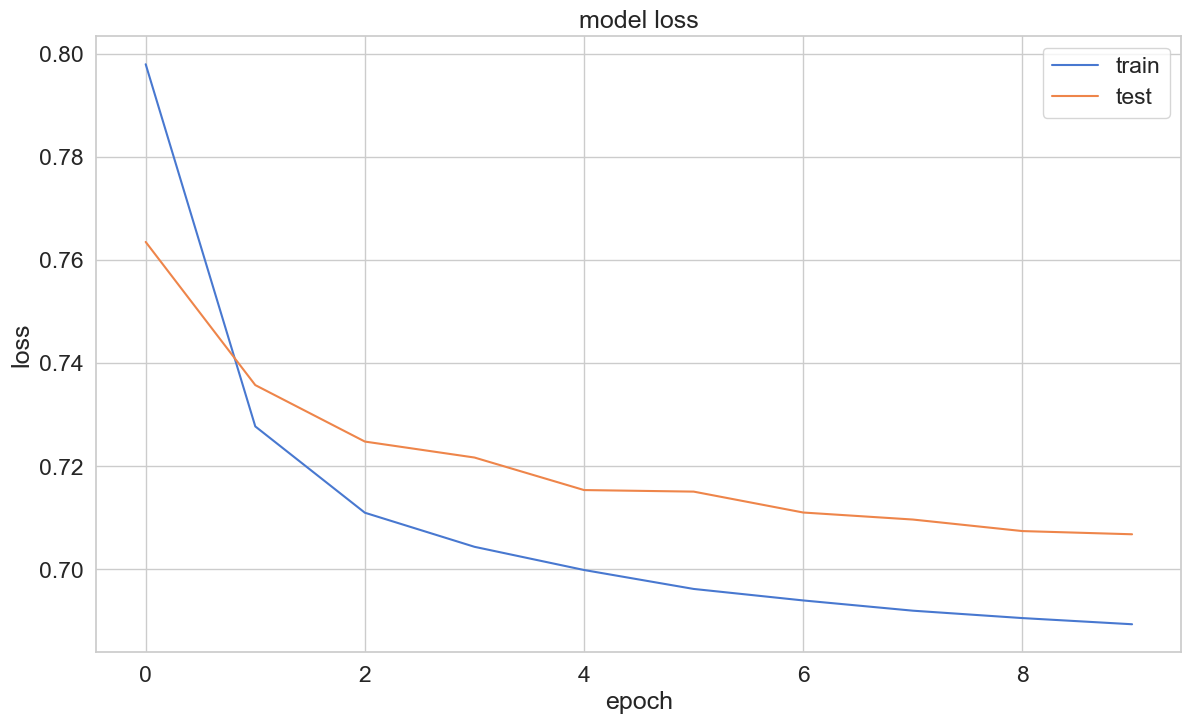

In [34]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [36]:
predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

1781/1781 [==============================] - 4s 2ms/step


,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.793900,0.001510
std,8.272714,0.038827
min,0.036020,0.000000
25%,0.241835,0.000000
50%,0.398331,0.000000
75%,0.632165,0.000000
max,1688.473676,1.000000


# 정상 거래 데이터들의 재구성 오류 분포

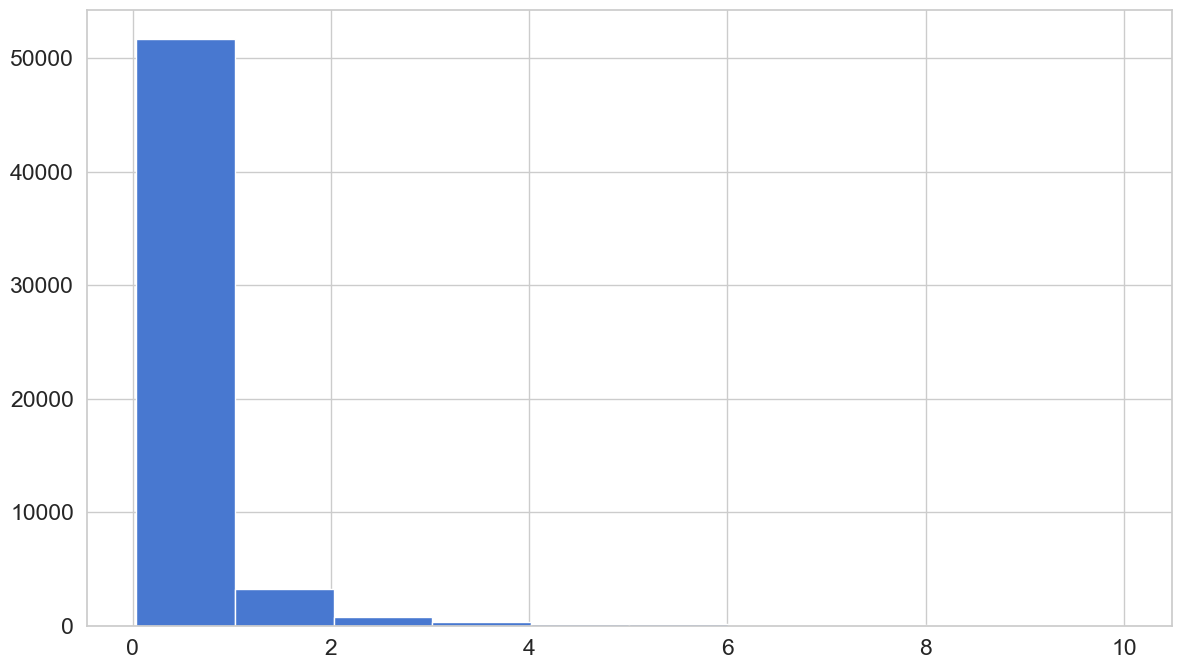

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

# 이상 거래 데이터들의 재구성 오류 분포

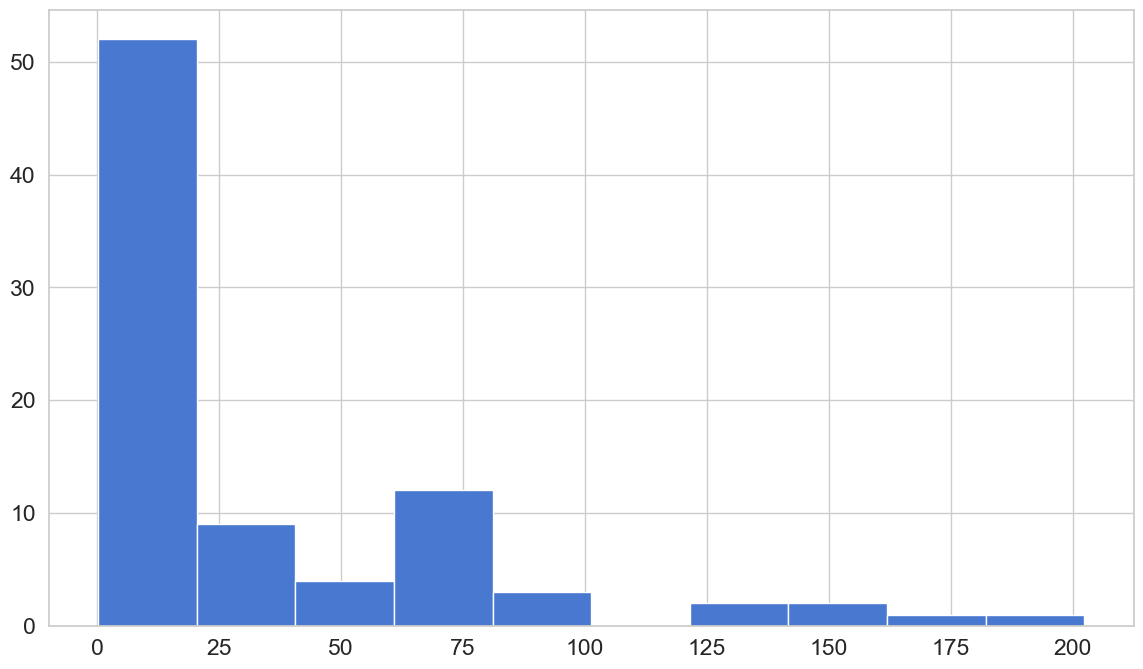

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

# ROC 곡선을 통한 평가

In [39]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

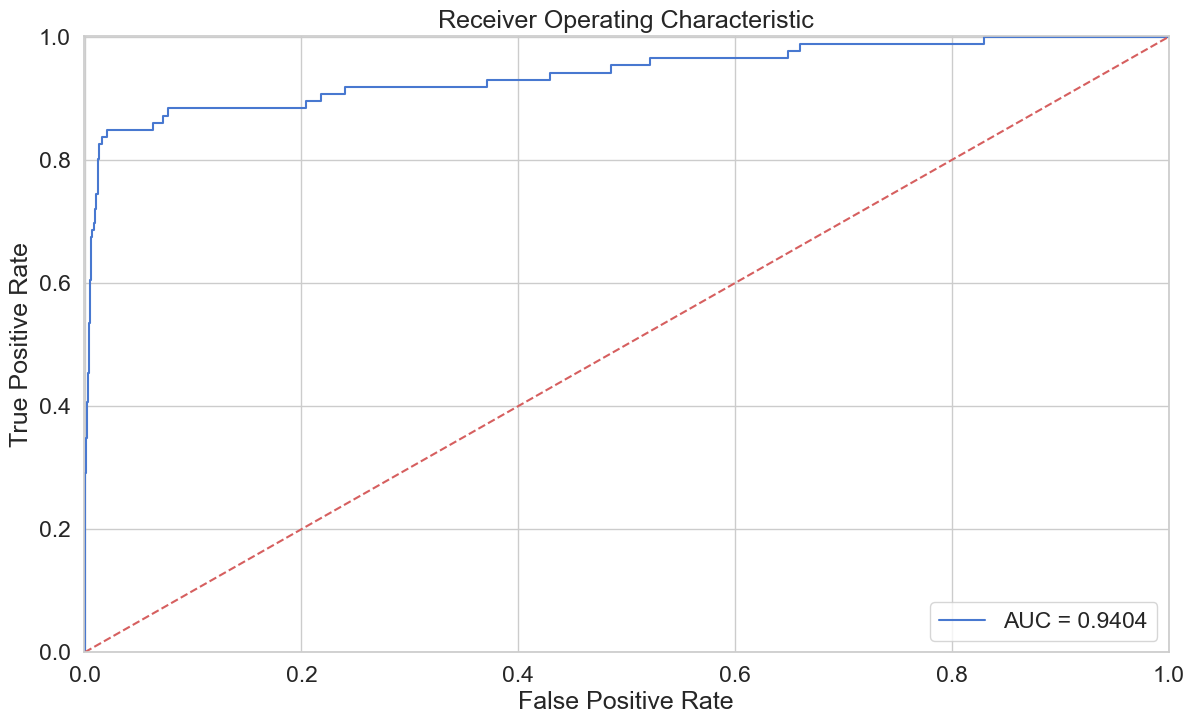

In [40]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [41]:
#ROC 곡선은 각 기준치(threshold)가 달라질 때마다 '틀린 것을 맞다고 할 확률'(false positive rate)에 따른 '맞는 것을 맞다고 한 확률'(true positive rate)을 그래프로 그린 것
#기본적으로, 파란색 곡선이 왼쪽 위 모퉁이에 가까워질수록 좋음

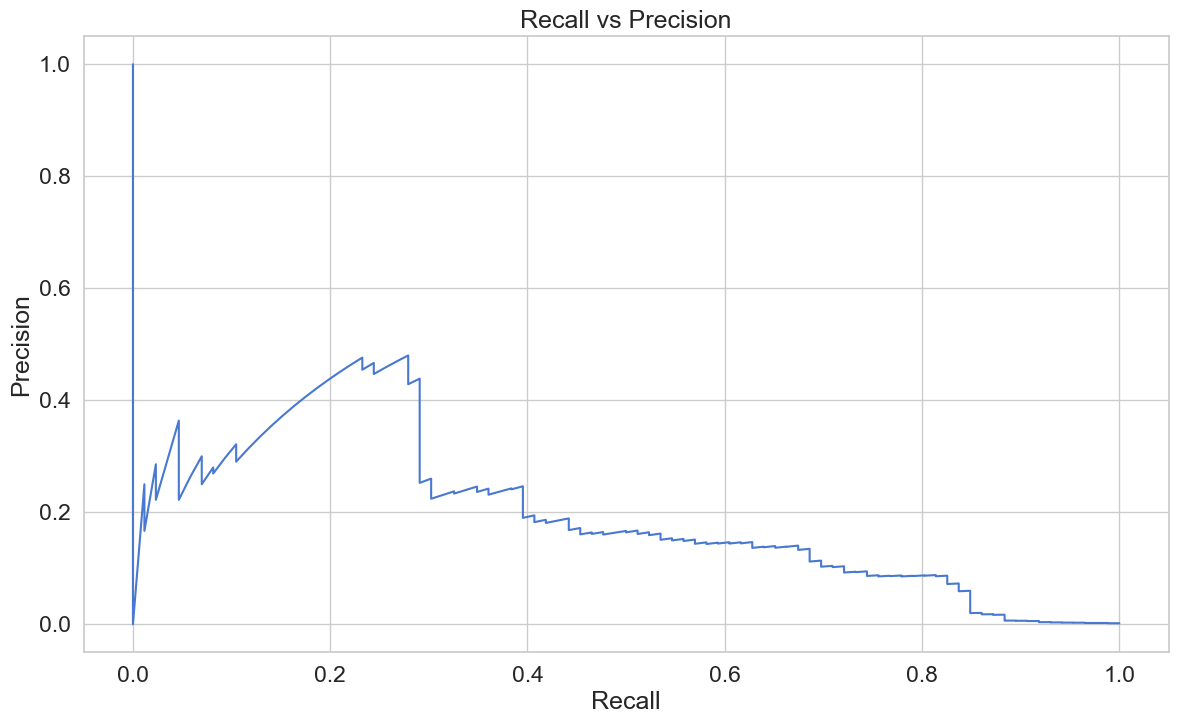

In [42]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


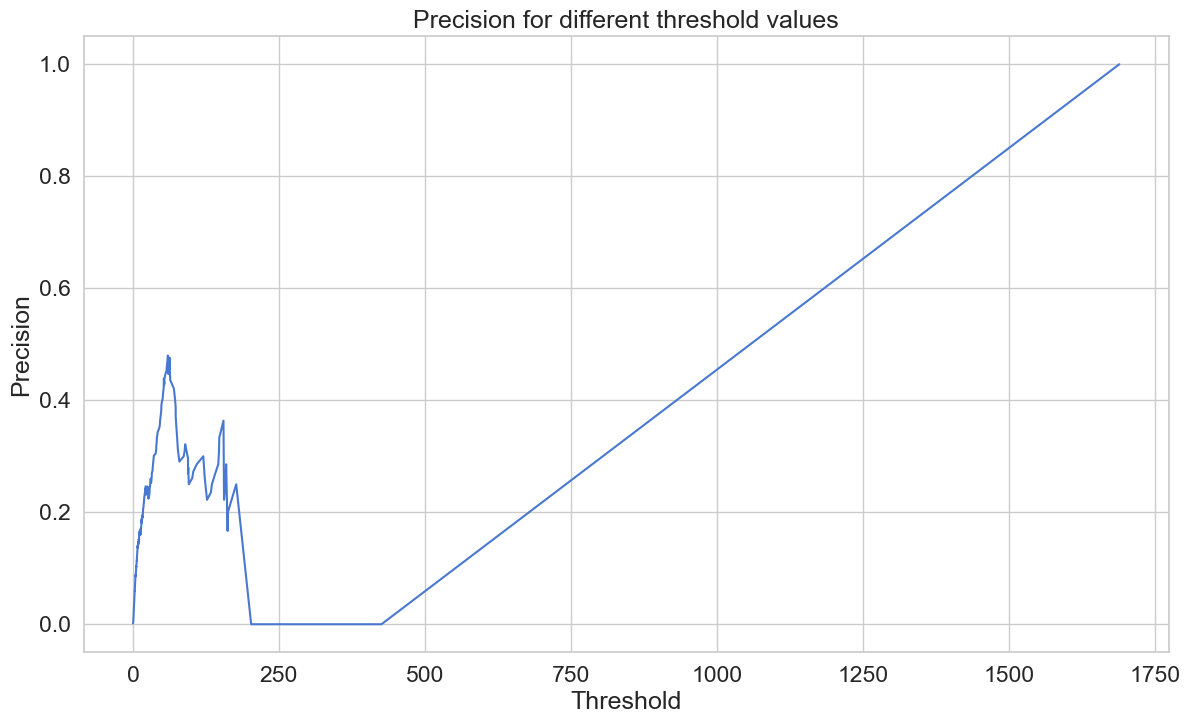

In [43]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

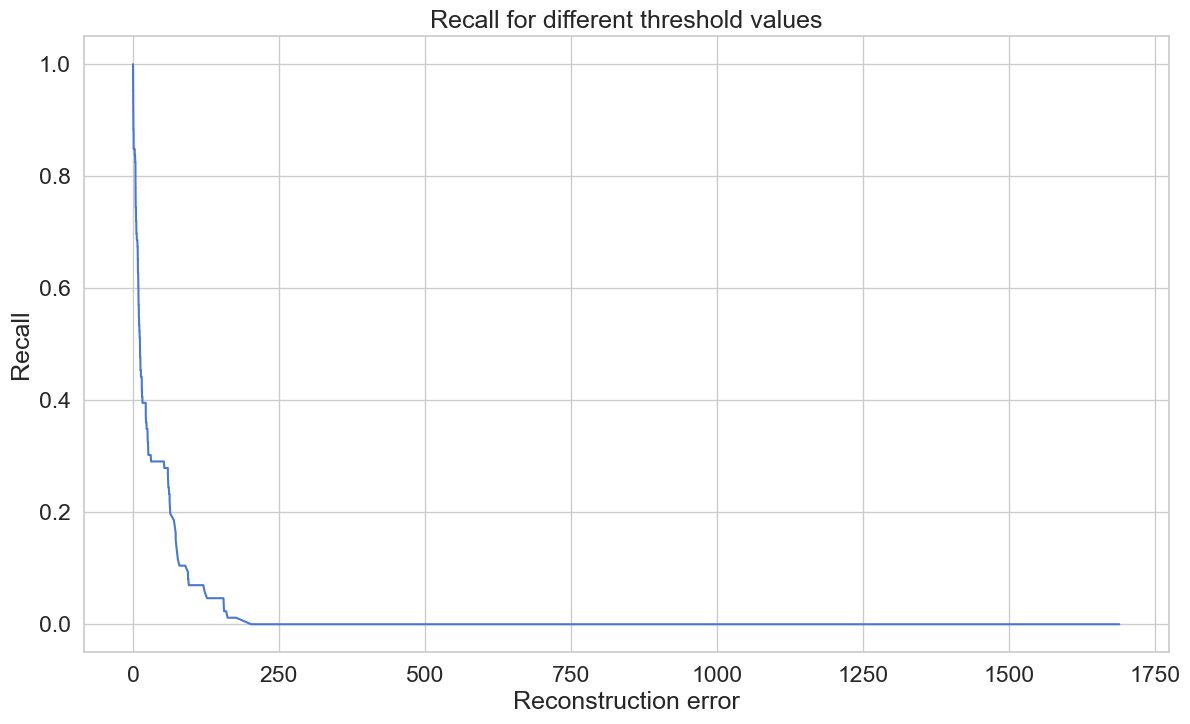

In [44]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [45]:
threshold = 2.9

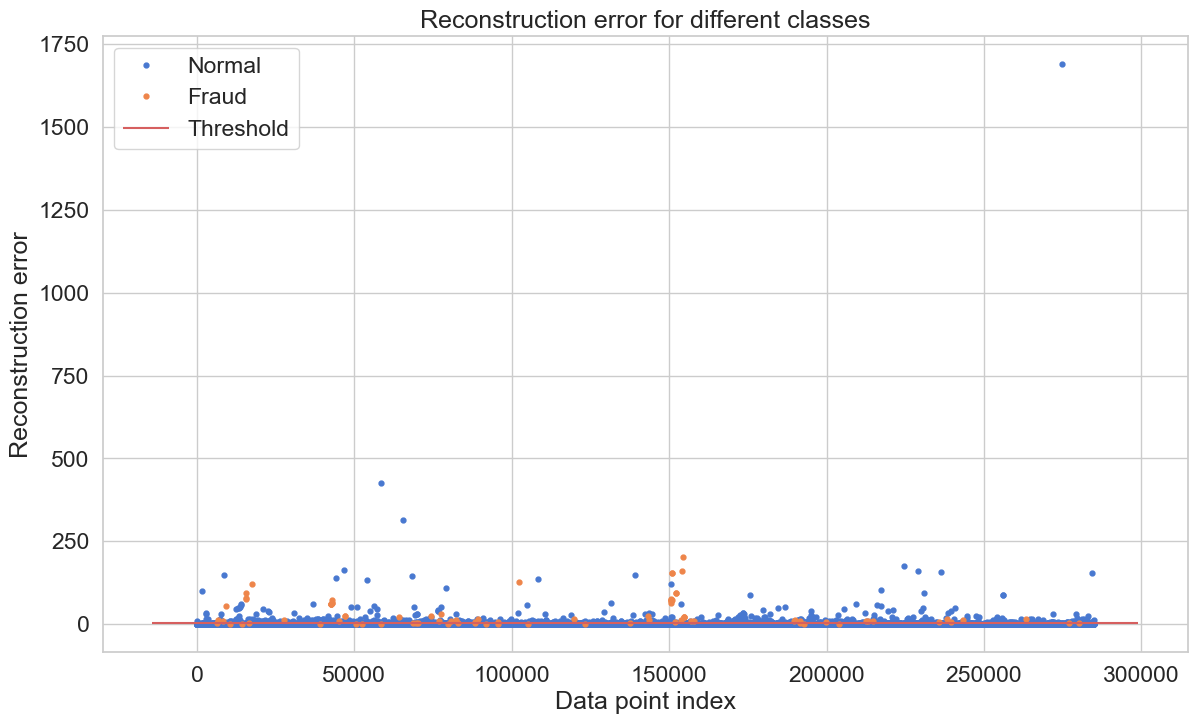

In [46]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


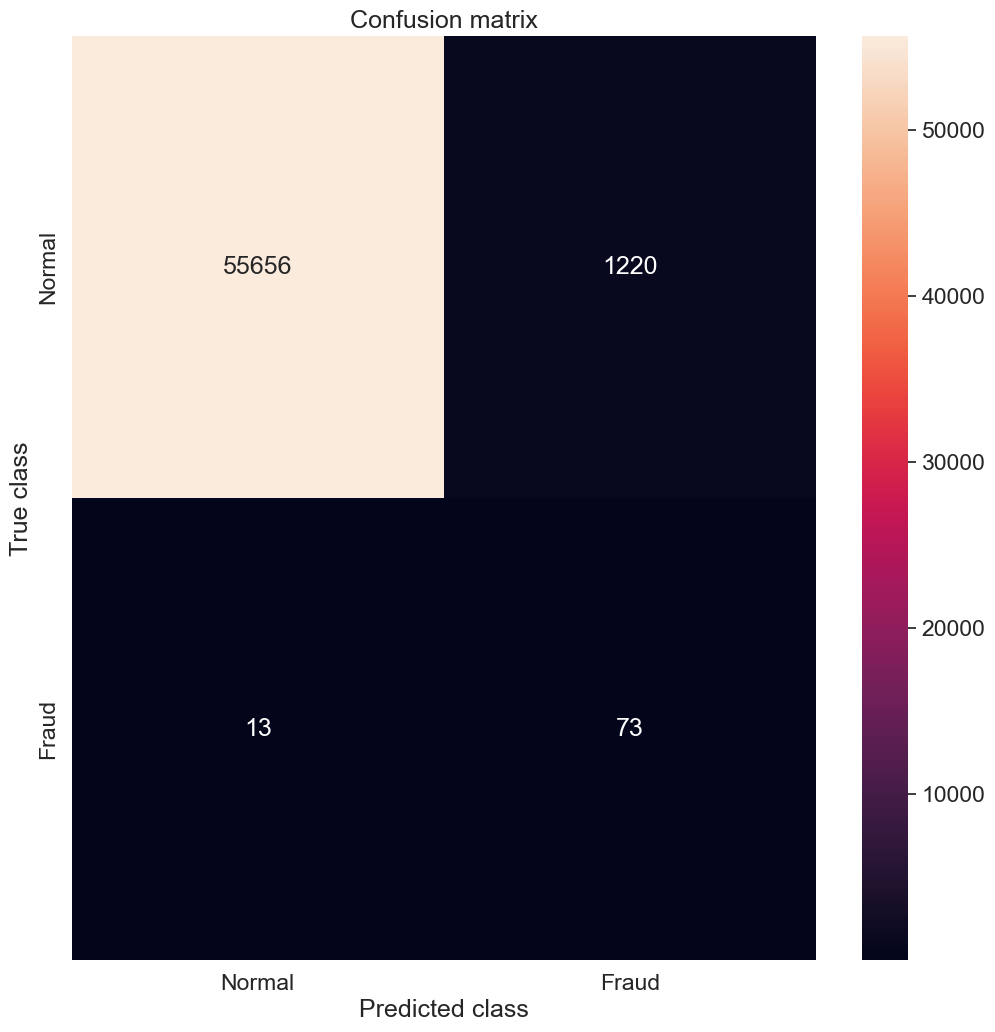

In [47]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()